In [1]:

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

In [2]:

from gluonts.dataset.repository import get_dataset, dataset_names
from gluonts.dataset.util import to_pandas
print(f"Available datasets: {dataset_names}")

Available datasets: ['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'exchange_rate_nips', 'electricity_nips', 'traffic_nips', 'solar_nips', 'wiki2000_nips', 'wiki-rolling_nips', 'taxi_30min', 'kaggle_web_traffic_with_missing', 'kaggle_web_traffic_without_missing', 'kaggle_web_traffic_weekly', 'm1_yearly', 'm1_quarterly', 'm1_monthly', 'nn5_daily_with_missing', 'nn5_daily_without_missing', 'nn5_weekly', 'tourism_monthly', 'tourism_quarterly', 'tourism_yearly', 'cif_2016', 'london_smart_meters_without_missing', 'wind_farms_without_missing', 'car_parts_without_missing', 'dominick', 'fred_md', 'pedestrian_counts', 'hospital', 'covid_deaths', 'kdd_cup_2018_without_missing', 'weather', 'm3_monthly', 'm3_quarterly', 'm3_yearly', 'm3_other', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly', 'm5', 'uber_tlc_daily', 'uber_tlc_hourly', 'airpassengers', 'australian_electricity_demand', 'electricity_hourly', 'electricity_weekly', 'rideshare_wit

/usr/local/anaconda3/envs/py_310/lib/python3.10/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [72]:
dataset_names
dataset = get_dataset("m4_hourly")
dataset.train

Map(fn=<gluonts.dataset.common.ProcessDataEntry object at 0x7f9034c58d60>, iterable=JsonLinesFile(path=PosixPath('/Users/partsi/.gluonts/datasets/m4_hourly/train/data.json.gz'), start=0, n=None))

type(entry): <class 'dict'>


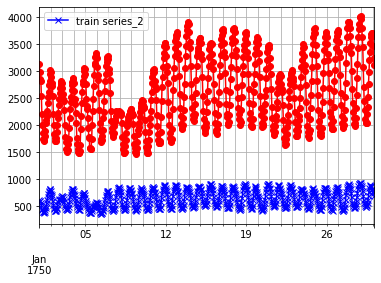

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Counter: 40


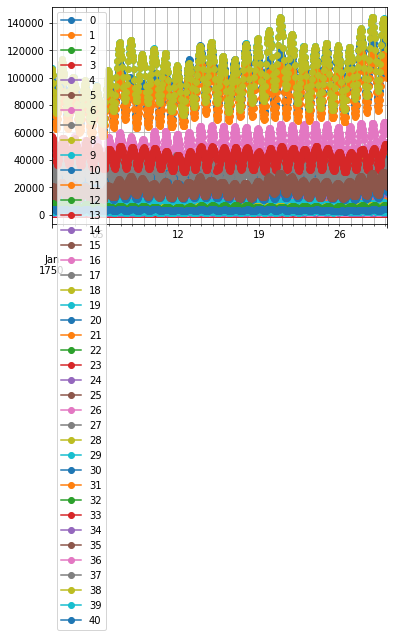

In [73]:
entry_iterable = iter(dataset.train)
#entry = next(iter(dataset.train))
entry = next(entry_iterable)
train_series = to_pandas(entry)
train_series.plot(c='b',marker='x')
#plt.grid(which="both")
#plt.legend(["train series"], loc="upper left")
entry_2 = next(entry_iterable)
#entry_2 = next(iter(dataset.train))
print(f"type(entry): {type(entry)}")
train_series_2 = to_pandas(entry_2)
train_series_2.plot(c='r',marker='o')
plt.grid(which="both")
plt.legend(["train series_2"], loc="upper left")

plt.show()
train_series==train_series_2
count = 0
plt.figure()
for entry_idx, entry_data in enumerate(dataset.train):
    count +=1
    cur_entry_data = to_pandas(entry_data)
    if entry_idx > 1:# and entry_idx <= 3:
        #print(f"{to_pandas(entry_data)}")
        
        print(f"{np.all(to_pandas(entry_data)==to_pandas(entry_data_prev))}")
        
    cur_entry_data.plot(marker='o',label=entry_idx)
    entry_data_prev = entry_data
    if entry_idx == 40:
        break
plt.grid(which="both")
plt.legend( loc="upper left")

print(f"Counter: {entry_idx}")

In [85]:
dataset.train

Map(fn=<gluonts.dataset.common.ProcessDataEntry object at 0x7f9034c58d60>, iterable=JsonLinesFile(path=PosixPath('/Users/partsi/.gluonts/datasets/m4_hourly/train/data.json.gz'), start=0, n=None))

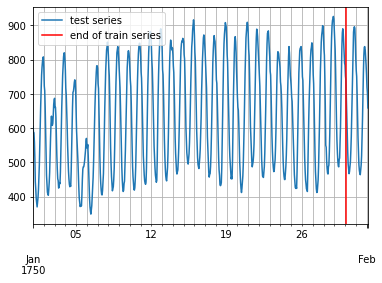

In [17]:
entry = next(iter(dataset.test))
test_series = to_pandas(entry)
test_series.plot()
plt.axvline(train_series.index[-1], color="r")  # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper left")
plt.show()

# NB: Why it seems that only first item from dataset.[train|test] is used in this analysis prediction. Other items have totally different means and variances. That is, is estimator with call predictor = estimator.train(dataset.train) really getting only the above series? No, all series are passed, but only 0th is analyzed in the tutorial. You can access the next dataseries with indexing "1", the third "2", etc. That is, all data series are getting predicted with above call.

In [75]:
print(
    f"Length of forecasting window in test dataset: {len(test_series) - len(train_series)}"
)
print(f"Recommended prediction horizon: {dataset.metadata.prediction_length}")
print(f"Frequency of the time series: {dataset.metadata.freq}")
print(
    f"Length of test dataset: {len(test_series)}"
)
print(
    f"Length of train dataset: {len(train_series)}"
)

Length of forecasting window in test dataset: 48
Recommended prediction horizon: 48
Frequency of the time series: H
Length of test dataset: 748
Length of train dataset: 700


# Custom data sets

In [76]:
N = 10  # number of time series
T = 100  # number of timesteps
prediction_length = 24
freq = "1H"
custom_dataset = np.random.normal(size=(N, T))
start = pd.Period("01-01-2019", freq=freq)  # can be different for each time series

In [77]:
start

Period('2019-01-01 00:00', 'H')

In [78]:
from gluonts.dataset.common import ListDataset

In [79]:
# train dataset: cut the last window of length "prediction_length", add "target" and "start" fields
train_ds = ListDataset(
    [{"target": x, "start": start} for x in custom_dataset[:, :-prediction_length]],
    freq=freq,
)
# test dataset: use the whole dataset, add "target" and "start" fields
test_ds = ListDataset(
    [{"target": x, "start": start} for x in custom_dataset], freq=freq
)

In [80]:
custom_dataset[:, :-prediction_length].shape

(10, 76)

In [81]:
custom_dataset[:, :].shape

(10, 100)

# Training an existing model (Estimator)
GluonTS comes with a number of pre-built models. All the user needs to do is configure some hyperparameters. The existing models focus on (but are not limited to) probabilistic forecasting. Probabilistic forecasts are predictions in the form of a probability distribution, rather than simply a single point estimate.

We will begin with GluonTS’s pre-built feedforward neural network estimator, a simple but powerful forecasting model. We will use this model to demonstrate the process of training a model, producing forecasts, and evaluating the results.

GluonTS’s built-in feedforward neural network (SimpleFeedForwardEstimator) accepts an input window of length context_length and predicts the distribution of the values of the subsequent prediction_length values. In GluonTS parlance, the feedforward neural network model is an example of an Estimator. In GluonTS, Estimator objects represent a forecasting model as well as details such as its coefficients, weights, etc.

In general, each estimator (pre-built or custom) is configured by a number of hyperparameters that can be either common (but not binding) among all estimators (e.g., the prediction_length) or specific for the particular estimator (e.g., number of layers for a neural network or the stride in a CNN).

Finally, each estimator is configured by a Trainer, which defines how the model will be trained i.e., the number of epochs, the learning rate, etc.

In [82]:
from gluonts.mx import SimpleFeedForwardEstimator, Trainer

In [83]:
estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=dataset.metadata.prediction_length,
    context_length=100,
    trainer=Trainer(ctx="cpu", epochs=5, learning_rate=1e-3, num_batches_per_epoch=100),
)

After specifying our estimator with all the necessary hyperparameters we can train it using our training dataset dataset.train by invoking the train method of the estimator. The training algorithm returns a fitted model (or a Predictor in GluonTS parlance) that can be used to construct forecasts.


In [87]:
predictor = estimator.train(dataset.train)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.52it/s, epoch=5/5, avg_epoch_loss=4.8]


In [49]:
dataset.metadata.prediction_length

48

# Visualize and evaluate forecasts
With a predictor in hand, we can now predict the last window of the dataset.test and evaluate our model’s performance.

GluonTS comes with the make_evaluation_predictions function that automates the process of prediction and model evaluation. Roughly, this function performs the following steps:

- Removes the final window of length prediction_length of the dataset.test that we want to predict
- The estimator uses the remaining data to predict (in the form of sample paths) the “future” window that was just removed
- The module outputs the forecast sample paths and the dataset.test (as python generator objects)

In [50]:
dataset.metadata.prediction_length

48

In [51]:
from gluonts.evaluation import make_evaluation_predictions

In [52]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

First, we can convert these generators to lists to ease the subsequent computations.

In [53]:
forecasts = list(forecast_it)
tss = list(ts_it)

We can examine the first element of these lists (that corresponds to the first time series of the dataset). Let’s start with the list containing the time series, i.e., tss. We expect the first entry of tss to contain the (target of the) first time series of dataset.test.

In [88]:
# first entry of the time series list
ts_entry = tss[0]
# the second entry of the time series
ts_entry = tss[1]

In [89]:
# first 5 values of the time series (convert from pandas to numpy)
np.array(ts_entry[:5]).reshape(
    -1,
)
#np.array(ts_entry).shape

array([3124., 2990., 2862., 2809., 2544.], dtype=float32)

In [90]:
len(forecasts)

414

In [93]:
# the first entry of dataset.test
dataset_test_entry_iterable = (iter(dataset.test))
dataset_test_entry = next(dataset_test_entry_iterable)
# the second entry of dataset.test
dataset_test_entry = next(dataset_test_entry_iterable)




In [94]:
# first 5 values
dataset_test_entry["target"][:5]

array([3124., 2990., 2862., 2809., 2544.], dtype=float32)

The entries in the forecast list are a bit more complex. They are objects that contain all the sample paths in the form of numpy.ndarray with dimension (num_samples, prediction_length), the start date of the forecast, the frequency of the time series, etc. We can access all this information by simply invoking the corresponding attribute of the forecast object.

In [95]:
# the first entry of the forecast list
forecast_entry = forecasts[0]
# the second entry of the forecast list
forecast_entry = forecasts[1]

In [96]:
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 100
Dimension of samples: (100, 48)
Start date of the forecast window: 1750-01-30 04:00
Frequency of the time series: <Hour>


We can also do calculations to summarize the sample paths, such as computing the mean or a quantile for each of the 48 time steps in the forecast window.

In [97]:
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

Mean of the future window:
 [2804.8267 2862.6257 2418.7603 2184.1482 2008.7354 2057.9756 2140.6433
 2019.703  2223.2122 2335.1267 2379.7913 2937.1582 3299.6768 3439.2825
 3346.7266 3643.318  3766.406  3594.3132 3719.946  3765.1863 3965.0498
 4193.382  2895.2156 2899.8665 3067.3027 3127.6965 2289.474  2199.4019
 2168.2437 2232.6182 2237.8562 1913.7039 2133.6626 2567.2754 2501.7705
 2991.2236 2903.521  3399.8066 3526.4365 3335.1816 3938.1865 3542.1104
 3929.7285 3774.1497 4204.931  4006.2876 3566.0957 3613.9385]
0.5-quantile (median) of the future window:
 [2878.6777 2781.5007 2460.041  2249.3333 2017.7804 2032.907  2149.457
 2007.5074 2286.7788 2383.428  2365.5212 2942.1855 3316.0913 3395.1484
 3400.4565 3567.5103 3665.3455 3527.4294 3748.232  3749.996  4073.0454
 4061.3525 2947.3594 2913.374  3107.4153 3076.3013 2325.6138 2230.3416
 2171.0132 2192.6165 2250.6726 1969.0568 2112.8813 2601.6138 2522.5867
 2929.7034 2858.1023 3376.6523 3495.2505 3478.096  3907.5398 3541.7905
 3977.4111 380

In [98]:
forecast_entry.mean.shape

(48,)

Forecast objects have a plot method that can summarize the forecast paths as the mean, prediction intervals, etc. The prediction intervals are shaded in different colors as a “fan chart”.

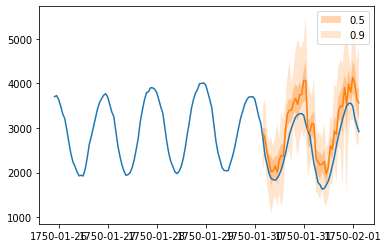

In [99]:
plt.plot(ts_entry[-150:].to_timestamp())
forecast_entry.plot(show_label=True)
plt.legend()

In [43]:
ts_entry[-150:].shape

(150, 1)

In [44]:
ts_entry[-150:].to_timestamp()

,0
1750-01-25 22:00:00,838.0
1750-01-25 23:00:00,823.0
1750-01-26 00:00:00,795.0
1750-01-26 01:00:00,750.0
1750-01-26 02:00:00,739.0
...,...
1750-01-31 23:00:00,785.0
1750-02-01 00:00:00,756.0
1750-02-01 01:00:00,719.0
1750-02-01 02:00:00,703.0


In [100]:
forecast_entry.mean.shape

(48,)

In [101]:
forecast_entry.mean

array([2804.8267, 2862.6257, 2418.7603, 2184.1482, 2008.7354, 2057.9756,
       2140.6433, 2019.703 , 2223.2122, 2335.1267, 2379.7913, 2937.1582,
       3299.6768, 3439.2825, 3346.7266, 3643.318 , 3766.406 , 3594.3132,
       3719.946 , 3765.1863, 3965.0498, 4193.382 , 2895.2156, 2899.8665,
       3067.3027, 3127.6965, 2289.474 , 2199.4019, 2168.2437, 2232.6182,
       2237.8562, 1913.7039, 2133.6626, 2567.2754, 2501.7705, 2991.2236,
       2903.521 , 3399.8066, 3526.4365, 3335.1816, 3938.1865, 3542.1104,
       3929.7285, 3774.1497, 4204.931 , 4006.2876, 3566.0957, 3613.9385],
      dtype=float32)

In [102]:
forecast_entry.samples.shape

(100, 48)

We can also evaluate the quality of our forecasts numerically. In GluonTS, the Evaluator class can compute aggregate performance metrics, as well as metrics per time series (which can be useful for analyzing performance across heterogeneous time series).

In [103]:
from gluonts.evaluation import Evaluator

In [104]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(tss, forecasts)

Running evaluation: 414it [00:00, 1070.46it/s]
/usr/local/anaconda3/envs/py_310/lib/python3.10/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/usr/local/anaconda3/envs/py_310/lib/python3.10/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/usr/local/anaconda3/envs/py_310/lib/python3.10/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/usr/local/anaconda3/envs/py_310/lib/python3.10/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserializa

In [105]:
len(tss) # number of different time series?

414

The aggregate metrics, agg_metrics, aggregate both across time-steps and across time series.

In [106]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 15527890.827716293,
    "abs_error": 11486436.30550766,
    "abs_target_sum": 145558863.59960938,
    "abs_target_mean": 7324.822041043146,
    "seasonal_error": 336.9046924038305,
    "MASE": 4.080286295753679,
    "MAPE": 0.2526915739507875,
    "sMAPE": 0.19121395551184145,
    "MSIS": 73.19820516085879,
    "QuantileLoss[0.1]": 5328893.414041901,
    "Coverage[0.1]": 0.10285829307568436,
    "QuantileLoss[0.5]": 11486436.286399364,
    "Coverage[0.5]": 0.57085346215781,
    "QuantileLoss[0.9]": 8330303.663471887,
    "Coverage[0.9]": 0.8951791465378421,
    "RMSE": 3940.5444836616543,
    "NRMSE": 0.5379713611582121,
    "ND": 0.07891265445094121,
    "wQuantileLoss[0.1]": 0.03660988607811721,
    "wQuantileLoss[0.5]": 0.07891265431966583,
    "wQuantileLoss[0.9]": 0.05722979320851363,
    "mean_absolute_QuantileLoss": 8381877.78797105,
    "mean_wQuantileLoss": 0.05758411120209889,
    "MAE_Coverage": 0.39839304884594745,
    "OWA": NaN
}


Individual metrics are aggregated only across time-steps.

In [113]:
item_metrics.head() # i.e., time-steps is time axis and time series refers to individual predicted time-series (?) The total number of rows is 414;
# len(item_metrics) 414

,item_id,forecast_start,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,ND,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,0,1750-01-30 04:00,4827.225911,2494.284180,31644.0,659.250000,42.371302,1.226402,0.077647,0.073756,0.078823,15.541467,1016.246405,0.020833,2494.284058,0.729167,1787.951807,1.000000
1,1,1750-01-30 04:00,228786.041667,20037.050781,124149.0,2586.437500,165.107988,2.528276,0.168291,0.152112,0.161395,16.068297,4131.287183,0.291667,20037.051392,1.000000,9967.104834,1.000000
2,2,1750-01-30 04:00,32447.046875,6335.494141,65030.0,1354.791667,78.889053,1.673102,0.087722,0.093281,0.097424,15.267044,3695.317920,0.000000,6335.494080,0.229167,2594.667480,0.854167
3,3,1750-01-30 04:00,303614.291667,19010.490234,235783.0,4912.145833,258.982249,1.529263,0.078179,0.076895,0.080627,17.082684,10138.646631,0.041667,19010.489746,0.500000,9875.909570,1.000000
4,4,1750-01-30 04:00,116774.270833,12358.906250,131088.0,2731.000000,200.494083,1.284214,0.092472,0.086563,0.094279,15.326298,4936.219116,0.020833,12358.905884,0.750000,8570.603564,1.000000


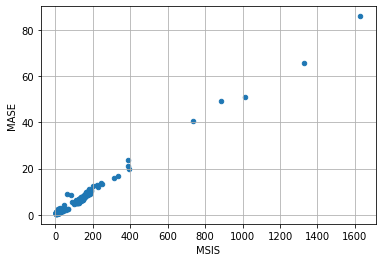

In [114]:
item_metrics.plot(x="MSIS", y="MASE", kind="scatter")
plt.grid(which="both")
plt.show()